# Code to make Figure 9
- Frequency of each SOM pattern by decade and month
- Notebook by Alice DuVivier (NCAR)
- February 2023

In [1]:
import pandas as pd
from minisom import MiniSom, asymptotic_decay
import xarray as xr
import cftime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from datetime import timedelta
from itertools import product
import pickle

### Set User-specified information

In [2]:
# set paired values for possible winning maps based on Sammon maps
vars_in          = ['aice_d']  # training dataset
som_grid_rows    = [3]    # (y-axis)
som_grid_cols    = [3]    # (x-axis)
sigs             = [1.0]
lrs              = [0.005]
nitrs            = [100000]
ranks            = [9]

In [3]:
# MANUAL CHANGING REQUIRED HERE
n = 0
var_in = vars_in[n]
som_row = som_grid_rows[n]
som_col = som_grid_cols[n]
sig = sigs[n]
lr = lrs[n]
n_iter = nitrs[n]
rank = ranks[n]

In [4]:
# set the location of the already extracted training data
sector_short = 'Ross'
path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/'+sector_short+'_analysis_v4/'
path_out = path_in+'figures_outline/'

In [5]:
# construct the input name from this, set as output for figure names
fin = 'som_'+sector_short+'_'+var_in+'_'+str(som_row)+'x'+str(som_col)+'_rank_'+str(rank)+'_sig'+str(sig)+'_lr'+str(lr)+'_iter'+str(n_iter)
print(fin)

som_Ross_aice_d_3x3_rank_9_sig1.0_lr0.005_iter100000


### Load training data to interpret SOM

In [6]:
def normalize_data(data):
    """
    Function for normalizing data prior to training using z-score
    """
    return (data - np.nanmean(data)) / np.nanstd(data)

In [7]:
# open file saved in earlier notebook (soms_antarctica-gettingdata.ipynb)
subset = xr.open_dataset(path_in+'training_data_region_'+sector_short+'_'+var_in+'.nc')

# assign to numpy array object
subsetarray = subset['train_data'].values

# set data
data = normalize_data(subsetarray)

# set data input length
input_length = subsetarray.shape[1]    # using preprocessed data array; Number of the elements of the vectors in input.


### Load Pickle with winning combos

In [8]:
# open pickle
with open(path_in+'/pickles/'+fin+'.p', 'rb') as infile:
    som = pickle.load(infile)

In [9]:
# double check qerror
qerr = som.quantization_error(data)
print('quantization error: '+str(qerr))

quantization error: 5.796123268140545


In [10]:
print(path_out)

/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/Ross_analysis_v4/figures_outline/


In [11]:
# create an empty dictionary using the rows and columns of SOM
keys = [i for i in product(range(som_row),range(som_col))]
winmap = {key: [] for key in keys}

In [12]:
# set frequencies
frequencies = 100.*((som.activation_response(data))/sum(sum(som.activation_response(data))))
#verify the total frequency is 100%
total = sum(sum(frequencies))

# grab the indices for the data within the SOM lattice
for i, x in enumerate(data):
    winmap[som.winner(x)].append(i) 

# create list of the dictionary keys
som_keys = list(winmap.keys())
print(f"Number of composite maps: {len(som_keys)}")
print(f"The rows and columns of the SOM lattice to use to grab SOM indexes:\n{[i for i in list(winmap.keys())]}")

Number of composite maps: 9
The rows and columns of the SOM lattice to use to grab SOM indexes:
[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


## Get frequencies

In [13]:
# choose decades we'll look at
# these will become coordinate arrays
decades = list(range(1980,2080,10))
decade_names = ['1980','1990','2000','2010','2020','2030','2040','2050','2060','2070']

months = list(range(7,10,1))
month_names = ['7','8','9']

nodes = list(range(0,len(som_keys),1))

### Look at total times possible by decade

In [14]:
# get all training times
all_times = subset.time
all_yy = all_times.dt.year
all_mm = all_times.dt.month

In [15]:
# assign some variables for years and months to do indexing later
#all_times['years'] = all_yy
#all_times['months'] = all_mm

# look at ways to slice and dice
#yy = [2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079]
#temp = all_times.isel(training_times = all_times.time.dt.year.isin([yy]))
#temp = all_times.isel(training_times = all_times.years.isin([yy]))

In [16]:
# breakdown all data into decades

# make numpy array to fill with decadal info
all_times_dec_array = np.zeros([len(decades)])
all_times_months_dec_array = np.zeros([len(decades),3])

for dec in decades:
    print('Getting Decadal dates for '+str(dec)+'s')
    if dec == 1980:
        count = 0
    else:
        count = count+1
    # set the start and end years for this decade
    yy_st = dec
    yy_ed = yy_st + 10
    yy = list(range(yy_st,yy_ed,1))
    #print(yy)
    # get number of data points for this range
    all_times_dec_array[count] = len(all_times.isel(training_times = all_times.time.dt.year.isin([yy])))
    temp = all_times.isel(training_times = all_times.time.dt.year.isin([yy]))
    
    # loop through months
    for mon in months:
        #print(mon)
        if mon == 7:
            m_count = 0
        else: 
            m_count = m_count+1
        # get number of points for this month
        all_times_months_dec_array[count,m_count] = len(temp.isel(training_times = temp.time.dt.month.isin([mon])))
    

Getting Decadal dates for 1980s
Getting Decadal dates for 1990s
Getting Decadal dates for 2000s
Getting Decadal dates for 2010s
Getting Decadal dates for 2020s
Getting Decadal dates for 2030s
Getting Decadal dates for 2040s
Getting Decadal dates for 2050s
Getting Decadal dates for 2060s
Getting Decadal dates for 2070s


In [17]:
# check the arrays
#print(all_times_dec_array)
#print(all_times_months_dec_array)

### Now calculate the total frequencies for each node by decade

In [18]:
## loop through the different som nodes
#for map_num in nodes:
#for map_num in range(len(som_keys)):

In [19]:
# make numpy arrays to fill with frequencies
node_frac_all_array = np.zeros([len(som_keys)])
node_frac_dec_array = np.zeros([len(som_keys),len(decades)])
node_frac_mon_dec_array = np.zeros([len(som_keys),len(decades),len(months)])

# loop through the different som nodes
#for map_num in nodes[0:1]:
for map_num in nodes:
    print('getting frequencies for node '+str(map_num))
    # get indices of training data that mapped to this node
    inds = winmap[som_keys[map_num]]
    freq = 100.*(len(inds)/len(subset.time))
    node_frac_all_array[map_num] = freq
    #print('total frequency of this node over all times: '+str(freq))
    # grab the training time metadata
    ds_sub = subset.isel(training_times=inds)
    time_sub = ds_sub.time

    # loop through each decade
    #for dec in decades[0:1]:
    for dec in decades:
        #print('Getting Decadal dates for '+str(dec)+'s')
        if dec == 1980:
            d_count = 0
        else:
            d_count = d_count+1    
        # set the start and end years for this decade
        yy_st = dec
        yy_ed = yy_st + 10
        yy = list(range(yy_st,yy_ed,1))
        #print(yy)
        # get total times for this decade and all nodes
        all_times_dec = len(all_times.isel(training_times = all_times.time.dt.year.isin([yy])))    
        # get total times for this decade and this node
        node_times_dec = len(time_sub.isel(training_times = time_sub.time.dt.year.isin([yy])))
        # now get frequency of this node for this decade (all months)
        freq = 100.*(node_times_dec/all_times_dec)
        node_frac_dec_array[map_num,d_count] = freq
        
        # subset these times so that we can do monthly analysis
        temp_all = all_times.isel(training_times = all_times.time.dt.year.isin([yy]))
        temp_node = time_sub.isel(training_times = time_sub.time.dt.year.isin([yy]))
        
        # loop through each month
        for mon in months:
        #for mon in months[0:1]:
            #print(mon)
            if mon == 7:
                m_count = 0
            else: 
                m_count = m_count+1
            # get total times for this decade and all nodes
            all_times_mon = len(temp_all.isel(training_times = temp_all.time.dt.month.isin([mon])))
            # get total times for this decade and this node
            node_times_mon = len(temp_node.isel(training_times = temp_node.time.dt.month.isin([mon])))
            # now get frequency of this node for this decade and this month
            freq = 100.*(node_times_mon/all_times_mon)
            node_frac_mon_dec_array[map_num,d_count,m_count] = freq

    

getting frequencies for node 0
getting frequencies for node 1
getting frequencies for node 2
getting frequencies for node 3
getting frequencies for node 4
getting frequencies for node 5
getting frequencies for node 6
getting frequencies for node 7
getting frequencies for node 8


In [20]:
print(node_frac_all_array.shape)
print(node_frac_dec_array.shape)
print(node_frac_mon_dec_array.shape)

(9,)
(9, 10)
(9, 10, 3)


In [21]:
# convert the numpy array to a xarray
node_frac_all = xr.DataArray(node_frac_all_array,dims=('node'))
node_frac_dec = xr.DataArray(node_frac_dec_array,dims=('node','decade'))
node_frac_mon_dec = xr.DataArray(node_frac_mon_dec_array,dims=('node','decade','month'))

In [22]:
nodes

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [23]:
# set coordinate arrays
node_frac_all['node'] = nodes

node_frac_dec['node'] = nodes
node_frac_dec['decade'] = decade_names

node_frac_mon_dec['node'] = nodes
node_frac_mon_dec['decade'] = decade_names
node_frac_mon_dec['month'] = month_names

In [24]:
# check the frequencies
print(sum(node_frac_all))
print(sum(node_frac_dec))
#print(sum(node_frac_dec.sel(decade='1980')))
print(sum(node_frac_mon_dec))
#print(sum(node_frac_mon_dec.sel(decade='1980',month='7')))

<xarray.DataArray ()>
array(100.)
Coordinates:
    node     int64 8
<xarray.DataArray (decade: 10)>
array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100.])
Coordinates:
  * decade   (decade) <U4 '1980' '1990' '2000' '2010' ... '2050' '2060' '2070'
    node     int64 8
<xarray.DataArray (decade: 10, month: 3)>
array([[100., 100., 100.],
       [100., 100., 100.],
       [100., 100., 100.],
       [100., 100., 100.],
       [100., 100., 100.],
       [100., 100., 100.],
       [100., 100., 100.],
       [100., 100., 100.],
       [100., 100., 100.],
       [100., 100., 100.]])
Coordinates:
  * decade   (decade) <U4 '1980' '1990' '2000' '2010' ... '2050' '2060' '2070'
  * month    (month) <U1 '7' '8' '9'
    node     int64 8


## Plot the results

In [25]:
# set some labeling things
title = sector_short+' SOM decadal changes in node frequency'
units = 'Frequency(%)'
node_labels=['0a','0b','0c','1a','1b','1c','2a','2b','2c']

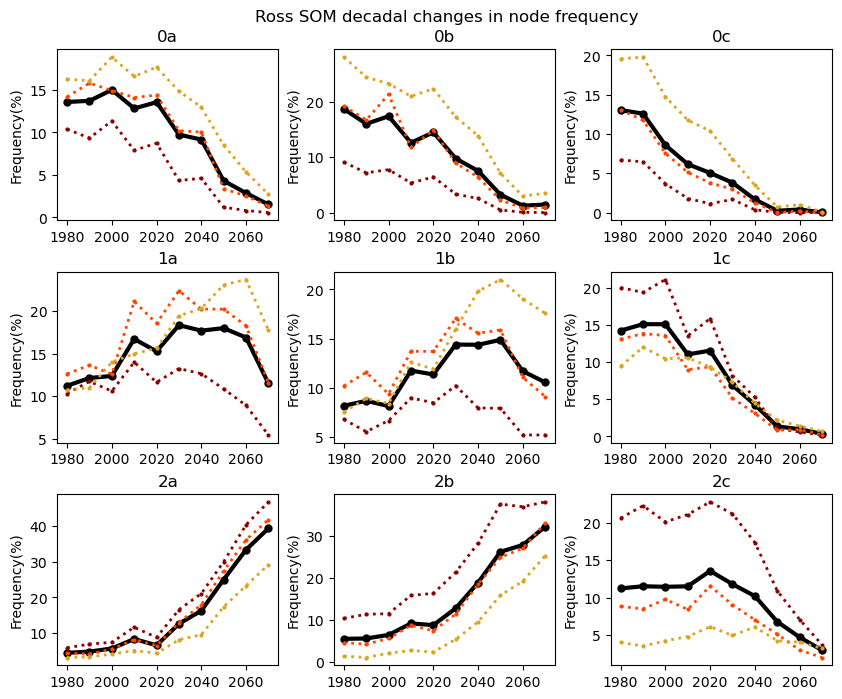

In [26]:
# Plot the frequency by decade over all month in the dataset

# set some of the plot info
fig, axs = plt.subplots(som_row, som_col, figsize=(10,8))
    
# loop through the different nodes to get the frequency for individual nodes
for map_num in range(len(som_keys)): 
    # make line plot of the frequencies
    cs = axs[som_keys[map_num][0],som_keys[map_num][1]].plot(decades,node_frac_dec.sel(node=map_num),
                                                             color='black',linestyle='-', linewidth=3,
                                                             marker='o', markersize=5)
    cs = axs[som_keys[map_num][0],som_keys[map_num][1]].plot(decades,node_frac_mon_dec.sel(node=map_num,month='7'),
                                                             color='darkred',linestyle=':', linewidth=2,
                                                             marker='o', markersize=2)
    cs = axs[som_keys[map_num][0],som_keys[map_num][1]].plot(decades,node_frac_mon_dec.sel(node=map_num,month='8'),
                                                             color='orangered',linestyle=':', linewidth=2,
                                                             marker='o', markersize=2)
    cs = axs[som_keys[map_num][0],som_keys[map_num][1]].plot(decades,node_frac_mon_dec.sel(node=map_num,month='9'),
                                                             color='goldenrod',linestyle=':', linewidth=2,
                                                             marker='o', markersize=2)
    
    # set labeling/titles
    axs[som_keys[map_num][0],som_keys[map_num][1]].set_ylabel(units,fontsize=10)
    axs[som_keys[map_num][0],som_keys[map_num][1]].set_title(node_labels[map_num])

# finalize figure 
plt.suptitle(title, fontsize=12, x=0.515, y=0.93)
fig.subplots_adjust(hspace=0.3,wspace=0.25)

# save figure
fout = path_out+'decadal_frequency_all_winter.png'
#plt.savefig(fout, bbox_inches='tight', dpi=200)


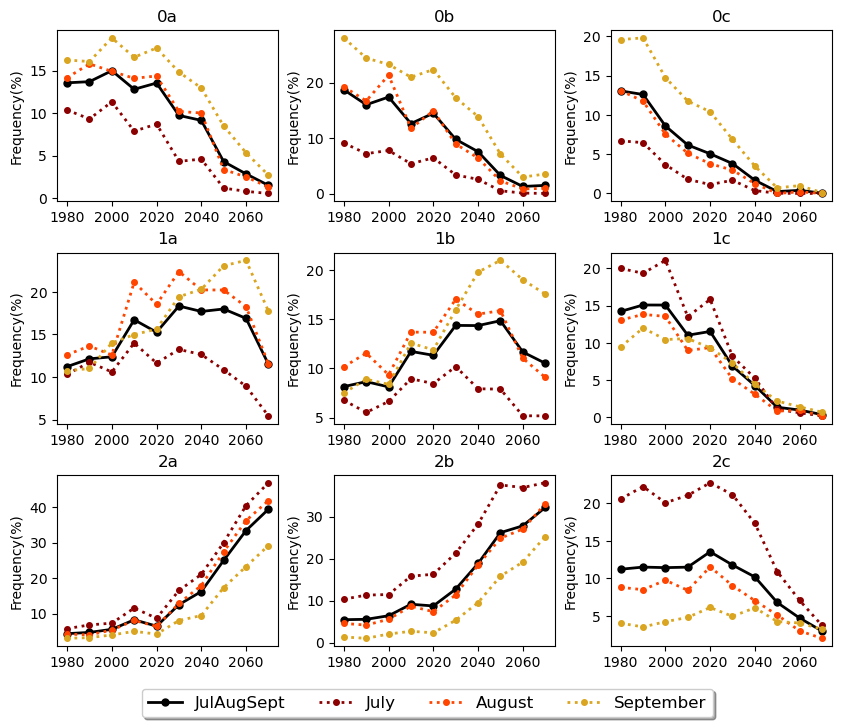

In [27]:
# Plot the frequency by decade over all month in the dataset

# set some of the plot info
fig, axs = plt.subplots(som_row, som_col, figsize=(10,8))
    
# loop through the different nodes to get the frequency for individual nodes
for map_num in range(len(som_keys)): 
    # make line plot of the frequencies
    ls0, = axs[som_keys[map_num][0],som_keys[map_num][1]].plot(decades,node_frac_dec.sel(node=map_num),
                                                             color='black',linestyle='-', linewidth=2,
                                                             marker='o', markersize=5)
    ls1, = axs[som_keys[map_num][0],som_keys[map_num][1]].plot(decades,node_frac_mon_dec.sel(node=map_num,month='7'),
                                                             color='darkred',linestyle=':', linewidth=2,
                                                             marker='o', markersize=4)
    ls2, = axs[som_keys[map_num][0],som_keys[map_num][1]].plot(decades,node_frac_mon_dec.sel(node=map_num,month='8'),
                                                             color='orangered',linestyle=':', linewidth=2,
                                                             marker='o', markersize=4)
    ls3, = axs[som_keys[map_num][0],som_keys[map_num][1]].plot(decades,node_frac_mon_dec.sel(node=map_num,month='9'),
                                                             color='goldenrod',linestyle=':', linewidth=2,
                                                             marker='o', markersize=4)
    
    # set labeling/titles
    axs[som_keys[map_num][0],som_keys[map_num][1]].set_ylabel(units,fontsize=10)
    axs[som_keys[map_num][0],som_keys[map_num][1]].set_title(node_labels[map_num])
    
# add legend
axs[som_keys[map_num][0],som_keys[map_num][1]].legend([ls0,ls1,ls2,ls3],
                                                      ['JulAugSept','July','August','September'],
                                                      ncol=4, bbox_to_anchor=(0.5,-0.2),
                                                      fancybox=True, shadow=True, fontsize=12)
# finalize figure 
#plt.suptitle(title, fontsize=12, x=0.515, y=0.93)
fig.subplots_adjust(hspace=0.3,wspace=0.25)

# save figure
fout = path_out+'fig9.png'
plt.savefig(fout, bbox_inches='tight', dpi=200)

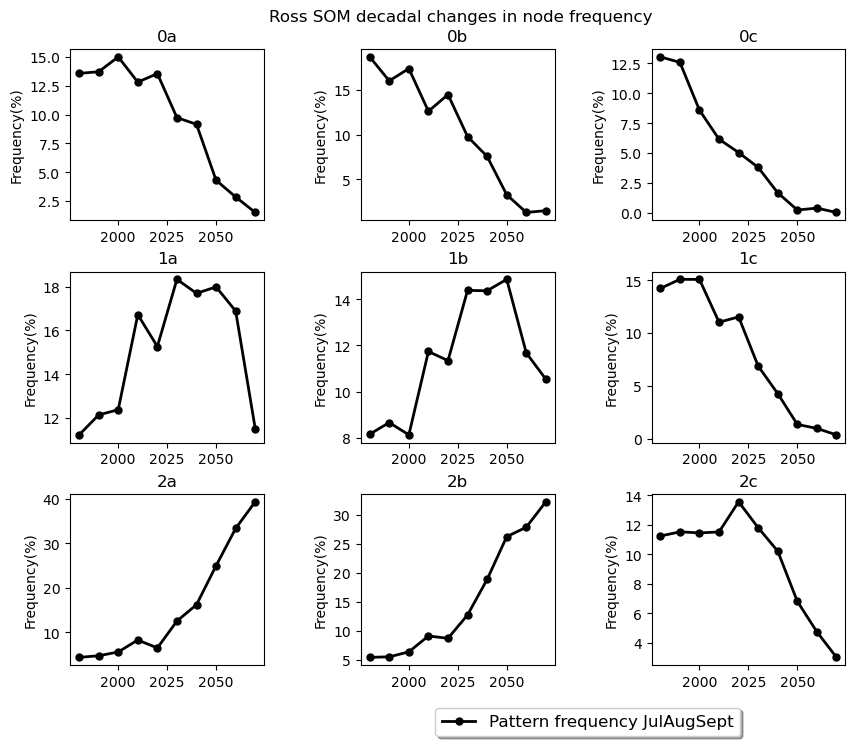

In [28]:
# Plot the frequency by decade over all month in the dataset

# set some of the plot info
fig, axs = plt.subplots(som_row, som_col, figsize=(10,8))
    
# loop through the different nodes to get the frequency for individual nodes
for map_num in range(len(som_keys)): 
    # make line plot of the frequencies
    ls0, = axs[som_keys[map_num][0],som_keys[map_num][1]].plot(decades,node_frac_dec.sel(node=map_num),
                                                             color='black',linestyle='-', linewidth=2,
                                                             marker='o', markersize=5)    
    # set labeling/titles
    axs[som_keys[map_num][0],som_keys[map_num][1]].set_ylabel(units,fontsize=10)
    #axs[som_keys[map_num][0],som_keys[map_num][1]].set_ylim(ymin=0,ymax=40)
    axs[som_keys[map_num][0],som_keys[map_num][1]].set_title(node_labels[map_num])
    
# add legend
axs[som_keys[map_num][0],som_keys[map_num][1]].legend([ls0],
                                                      ['Pattern frequency JulAugSept'],
                                                      ncol=4, bbox_to_anchor=(0.5,-0.2),
                                                      fancybox=True, shadow=True, fontsize=12)
# finalize figure 
plt.suptitle(title, fontsize=12, x=0.515, y=0.93)
fig.subplots_adjust(hspace=0.3,wspace=0.5)

# save figure
fout = path_out+'ams_polar.png'
#plt.savefig(fout, bbox_inches='tight', dpi=200)